In [1]:
#Cell 1 - Import Libraries & Setup Paths

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# Append project root if needed
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

# Define directories for outputs
figures_dir = "../reports/figures"
text_dir = "../reports/text"
processed_dir = "../data/processed"

os.makedirs(figures_dir, exist_ok=True)
os.makedirs(text_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)


In [2]:
#Cell 2 - Load Feature-Engineered Data
# Load the processed and encoded dataset from previous steps

data_path = os.path.join(processed_dir, "train_feature_engineered_encoded.csv")
df = pd.read_csv(data_path)
print("Processed data loaded. Shape:", df.shape)

# Save a sample for reference
sample_path = os.path.join(text_dir, "tuning_data_sample.csv")
df.head(10).to_csv(sample_path, index=False)


Processed data loaded. Shape: (1399, 112)


In [3]:
#Cell 3 - Prepare Features and Target (Numeric Only)
# Select only numeric columns to avoid type conversion issues

numeric_df = df.select_dtypes(include=['number'])

# Ensure 'SalePrice' is our target
if 'SalePrice' not in numeric_df.columns:
    raise ValueError("Target column 'SalePrice' not found.")

y = numeric_df['SalePrice']
X = numeric_df.drop(columns=['SalePrice', 'Id'], errors='ignore')

# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (1119, 69)
Validation set shape: (280, 69)


In [4]:
#Cell 4 - Setup and Run Hyperparameter Tuning with GridSearchCV
# Define the parameter grid for RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV (using 5-fold CV)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training set
grid_search.fit(X_train, y_train)

# Compute best RMSE (note: GridSearchCV returns negative MSE)
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best CV RMSE: {best_rmse:.2f}")
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV RMSE: 21693.82
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [5]:
#Cell 5 - Save Hyperparameter Tuning Results
# Save the best parameters and CV results to a text file for reference

tuning_results_path = os.path.join(text_dir, "rf_grid_search_results.txt")
with open(tuning_results_path, "w") as f:
    f.write(f"Best CV RMSE: {best_rmse:.2f}\n")
    f.write("Best Parameters:\n")
    f.write(str(grid_search.best_params_) + "\n\n")
    f.write("All CV results:\n")
    f.write(pd.DataFrame(grid_search.cv_results_).to_string())

print("Hyperparameter tuning results saved to:", tuning_results_path)


Hyperparameter tuning results saved to: ../reports/text/rf_grid_search_results.txt


In [6]:
#Cell 6 - Evaluate Best Model on Validation Set
# Retrieve the best estimator from grid search

best_rf = grid_search.best_estimator_

# Evaluate on validation data
from sklearn.metrics import mean_squared_error
y_val_pred = best_rf.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {val_rmse:.2f}")

# Save validation evaluation to text file
val_eval_path = os.path.join(text_dir, "rf_validation_evaluation.txt")
with open(val_eval_path, "w") as f:
    f.write(f"Validation RMSE: {val_rmse:.2f}\n")
print("Validation evaluation saved to:", val_eval_path)


Validation RMSE: 21478.68
Validation evaluation saved to: ../reports/text/rf_validation_evaluation.txt


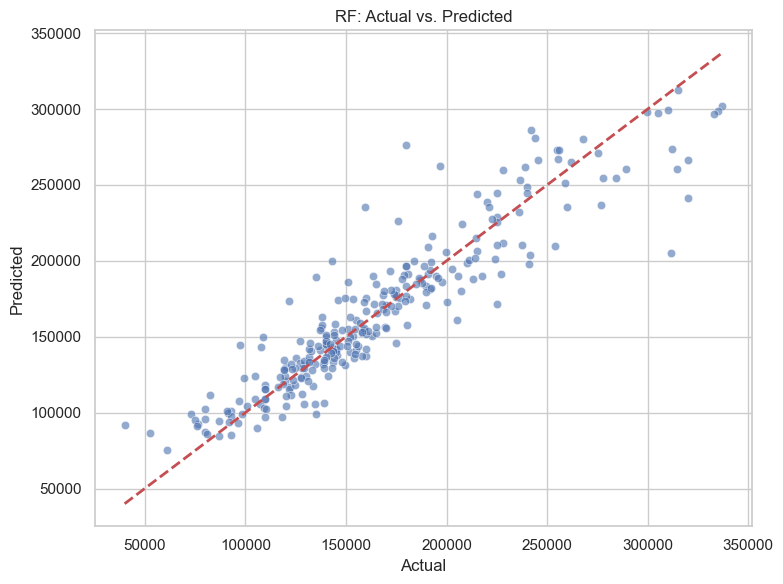

In [7]:
#Cell 7 - Visualize Actual vs. Predicted on Validation Set
# Import visualization function from evaluation module

from src.evaluation import plot_actual_vs_predicted

plot_path = os.path.join(figures_dir, "rf_actual_vs_predicted.png")
plot_actual_vs_predicted(y_val, y_val_pred, title="RF: Actual vs. Predicted", save_path=plot_path)


In [8]:
#Cell 8 - Save the Best Model

from src.models import save_model

model_save_path = os.path.join(processed_dir, "rf_best_model.pkl")
save_model(best_rf, model_save_path)


Model saved to ../data/processed/rf_best_model.pkl
